In [1]:
# General imports
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams["figure.figsize"] = (16,7)
mpl.rcParams["image.origin"] = "lower"
mpl.rcParams["image.interpolation"] = "nearest"
import scipy

# pysynphot - work with spectra
import pysynphot as S
import webbpsf

# Astropy - read files
from astropy.io import fits
from astropy.table import Table

# Grizli - sim
from grizli.model import GrismFLT

# Progress bar
from tqdm import tqdm
from IPython.display import clear_output

os.chdir("/Users/keith/astr/research_astr/summer-roman-project/6) predictable_extract/fits")

/Users/keith/miniconda3/envs/grizli-env/lib/python3.12/site-packages/pysynphot/refs.py:117: UserWarning: No graph or component tables found; functionality will be SEVERELY crippled. No files found for /Users/keith/PYSYN_CDBS/mtab/*_tmg.fits
  warnings.warn('No graph or component tables found; '
/Users/keith/miniconda3/envs/grizli-env/lib/python3.12/site-packages/pysynphot/refs.py:124: UserWarning: No thermal tables found, no thermal calculations can be performed. No files found for /Users/keith/PYSYN_CDBS/mtab/*_tmt.fits
  warnings.warn('No thermal tables found, '


In [2]:
# Define slice dimensions
half_slice_width = 15 # x width
half_slice_length = 500 # y length
wave = np.linspace(10000, 20000, (2*half_slice_length)+1) # wavelength array

# Read in catalog
hlss_tbl = Table.read("/Users/keith/astr/research_astr/FOV0/catalogs/MOT_SCA1_roll_0_dither_0x_0y_cut_zcut.txt",
                      format='ascii')
hlss_tbl = hlss_tbl.group_by("MODIMAGE")
hlss_tbl.groups[0].sort("MAG_F1500W", reverse=True)
hlss_tbl.groups[1].sort("MAG_F1500W", reverse=True)

# Read in sensitivity and bandpass files
sens = Table.read("/Users/keith/astr/research_astr/summer-roman-project/toy_configs/sens_0720_2020.fits", format="fits")

df = Table.read("/Users/keith/astr/research_astr/FOV0/FOV0_SEDs/wfirst_wfi_f158_001_syn.fits", format='fits')
bp = S.ArrayBandpass(df["WAVELENGTH"], df["THROUGHPUT"])

SED_dir = "/Users/keith/astr/research_astr/FOV0/FOV0_SEDs" # Define SED directory

# Name all relevant files & load in catalog
direct_file = "ready_direct_GRS_FOV0_roll0_dx0_dy0_SCA1_direct_final.fits"
empty_seg = "empty_seg.fits"

In [3]:
# Prepare shape-defining equations
# GALAXY ellipses
A = lambda theta, a, b: ((np.sin(theta)**2)/(a**2)) + ((np.cos(theta)**2)/(b**2))
B = lambda theta, a, b: 2 * np.sin(theta) * np.cos(theta) * ((1/b**2) - (1/a**2))
C = lambda theta, a, b: ((np.sin(theta)**2)/(b**2)) + ((np.cos(theta)**2)/(a**2))

gen_ellipse = lambda x,y,x_0,y_0, ell: (A(*ell) * (x - x_0)**2) + (B(*ell) * (x - x_0) * (y - y_0)) + (C(*ell) * (y - y_0)**2)

# STAR circle
gen_cirl = lambda x,y,x_0,y_0: (x-x_0)**2 + (y-y_0)**2

star_radius = lambda mag: 4663 * 10**(-0.1587 * mag) + 1.596

In [4]:
def find_object(x, y, distance):
    condition = (abs(hlss_tbl["X_IMAGE"] - x) <= distance) & (abs(hlss_tbl["Y_IMAGE"] - y) <= distance)
    object = hlss_tbl[np.where(condition)][0]

    return object

def load_template(object):

    _is_star = object["MODIMAGE"]
    Z = object["Z"]
    mag = object["MAG_F1500W"]

    if _is_star:
        sed = "ukg0v.dat"
        data = Table.read(os.path.join(SED_dir, sed), format="ascii")[1770 : 3770]
        
        template = S.ArraySpectrum(data["col1"], data["col2"], waveunits="angstroms", fluxunits="flam").redshift(Z)
    
    else:
        sed = "SED:rest:gal.{0}.fits".format(object["SPECTEMP"])
        data = Table.read(os.path.join(SED_dir, sed), format="fits")

        template = S.ArraySpectrum(data["wavelength"], data["flux"], waveunits="angstroms", fluxunits="flam").redshift(Z)

    template = template.renorm(mag, "abmag", bp)
    template.convert("flam")

    interpolated_sens = np.interp(template.wave, sens["WAVELENGTH"], sens["SENSITIVITY"])
    flux = template.flux * interpolated_sens
    flux = scipy.stats.binned_statistic(template.wave, flux, statistic="sum", bins=1001)[0]
    wave = np.linspace(template.wave.min(), template.wave.max(), 1001)

    template = S.ArraySpectrum(wave, flux, waveunits="angstroms", fluxunits="flam")

    return template

def print_cutout(object, data):
    x_0 = object["X_IMAGE"]
    y_0 = object["Y_IMAGE"]

    fig, (ax1, ax2) = plt.subplots(1, 2)

    vmin=0 ; vmax=0.00001

    ax1.imshow(data, vmin=vmin, vmax=vmax, cmap="Greys_r")
    ax1.axvline(x_0 - half_slice_width - 5)
    ax1.axvline(x_0 + half_slice_width + 5)
    ax1.axhline(y_0 - half_slice_length)
    ax1.axhline(y_0 + half_slice_length)

    ax2.imshow(data, vmin=vmin, vmax=vmax, cmap="Greys_r")
    ax2.set_xlim(x_0 - half_slice_width - 10, x_0 + half_slice_width + 10)
    ax2.set_ylim(y_0 - half_slice_length - 10, y_0 + half_slice_length + 10)

    plt.show()

    return 0

def extraction(object, data, half_width=3):
    x_0 = int(object["X_IMAGE"])
    y_0 = int(object["Y_IMAGE"])

    x_min = x_0 - half_width
    x_max = x_0 + half_width
    y_min = y_0 - half_slice_length - 1
    y_max = y_0 + half_slice_length

    cutout = data[max(0, y_min) : y_max, max(0, x_min) : x_max]
    
    max_fluxes = []
    sum_fluxes = []
    for ii in reversed(range(cutout.shape[0])):
        max_fluxes.append(cutout[ii].max())
        sum_fluxes.append(cutout[ii].sum())

    max_fluxes = np.asarray(max_fluxes)
    sum_fluxes = np.asarray(sum_fluxes)

    extraction = {"max": max_fluxes,
                  "sum": sum_fluxes,
                  "bounds": (y_min, y_max, x_min, x_max)}

    return extraction

def sens_correct(extractions):
    y_min, y_max = extractions["bounds"][0:2]

    wave_min = max(10000, 10000 + ((10000/1001) * (y_max - 4088)))
    wave_max = min(20000, 20000 + ((10000/1001) * y_min))

    fluxes = {}

    for key in extractions.keys():
        if key == "bounds":
            continue

        flux = extractions[key]
        bins = len(flux)
        if not bins:
            continue
        wave = np.linspace(wave_min, wave_max, bins)

        fluxes[key] = {"wave": wave, "flux": flux}

    return fluxes

def main(object, data, show_cutout=False, plot=True, store=False, ax=None):

    if show_cutout:
        print_cutout(object, data)

    try:
        extractions = extraction(object, data)
    except ValueError:
        print(object["NUMBER"], "caused an error")
        return 1

    sens_corrected_spec = sens_correct(extractions)
    sens_corrected_spec["template"] = load_template(object)

    if ax is None:
        fig, ax = plt.subplots()
        
    ax.plot(sens_corrected_spec["template"].wave, sens_corrected_spec["template"].flux, c='r', alpha=0.5, label=f"template")

    try:
        max_corr_spec = sens_corrected_spec["max"]
        ax.plot(max_corr_spec["wave"], max_corr_spec["flux"], c='b', linestyle=':', alpha=0.5, label="Max: Sensitivity correction")
    except KeyError:
        ax.plot(10000, 0, label="No Max Extract")
    try:
        sum_corr_spec = sens_corrected_spec["sum"]
        ax.plot(sum_corr_spec["wave"], sum_corr_spec["flux"], c='c', linestyle='--', alpha=0.5, label="Sum: Sensitivity correction")
    except KeyError:
        ax.plot(10000, 0, label="No Sum Extract")

    ax.set_title(f"Object: {object["NUMBER"]}")
    ax.set_xlabel("Wavelength [Angstroms]")
    ax.set_ylabel("Flux [Flam]")
    ax.legend();

    if plot:
        plt.show()

    if store:
        return ax

    return sens_corrected_spec

In [5]:
pad = 100
roman_sim = GrismFLT(direct_file=direct_file, seg_file=empty_seg, pad=pad)



Image cutout: x=slice(0, 4088, None), y=slice(0, 4088, None) [Out of range]
ready_direct_GRS_FOV0_roll0_dx0_dy0_SCA1_direct_final.fits / Pad ref HDU with 264 pixels
ready_direct_GRS_FOV0_roll0_dx0_dy0_SCA1_direct_final.fits / blot segmentation empty_seg.fits[0]
The following task in the stsci.skypac package can be run with TEAL:
                                    skymatch                                    
The following tasks in the drizzlepac package can be run with TEAL:
    astrodrizzle       config_testbed      imagefindpars           mapreg       
       photeq            pixreplace           pixtopix            pixtosky      
  refimagefindpars       resetbits          runastrodriz          skytopix      
     tweakback            tweakreg           updatenpol
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...


  0%|          | 0/5 [00:00<?, ?it/s]

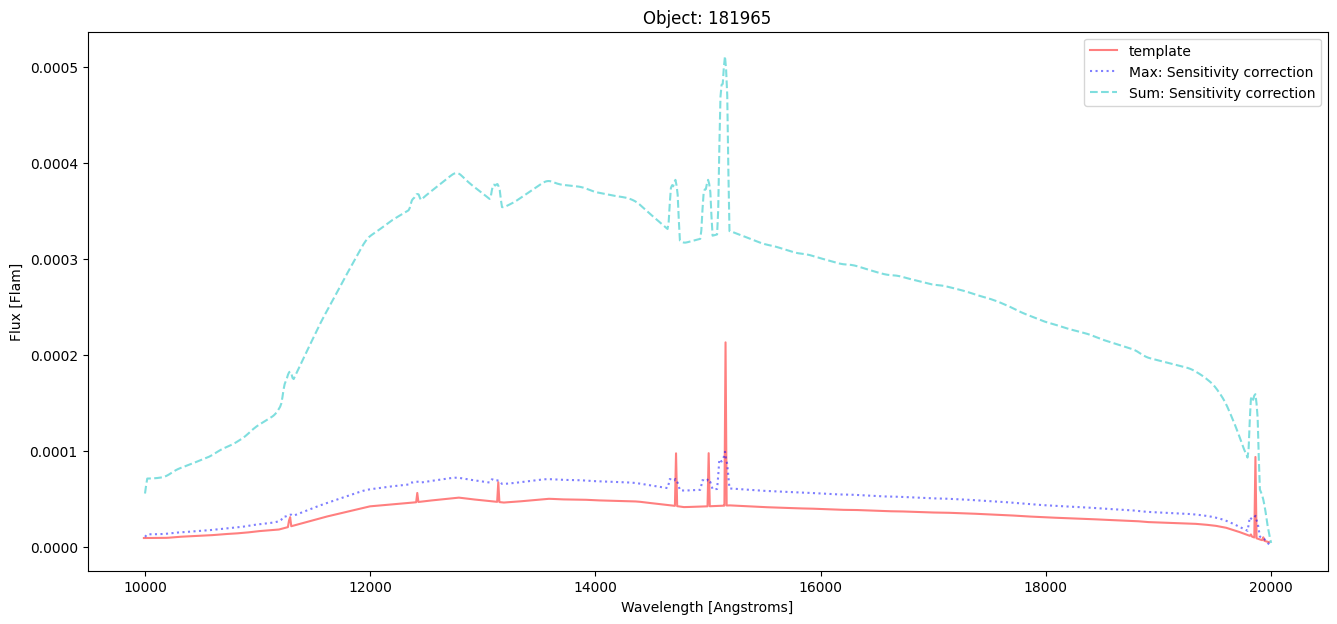

 20%|██        | 1/5 [00:00<00:00,  5.67it/s]

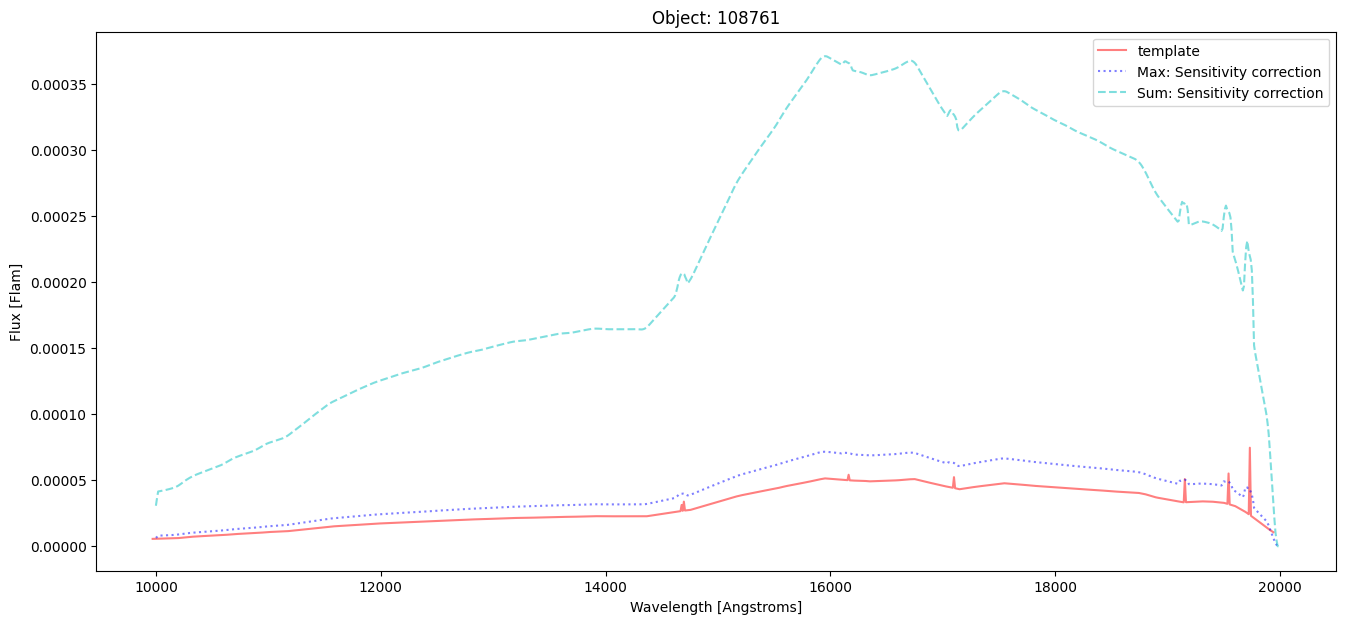

 40%|████      | 2/5 [00:00<00:00,  5.72it/s]

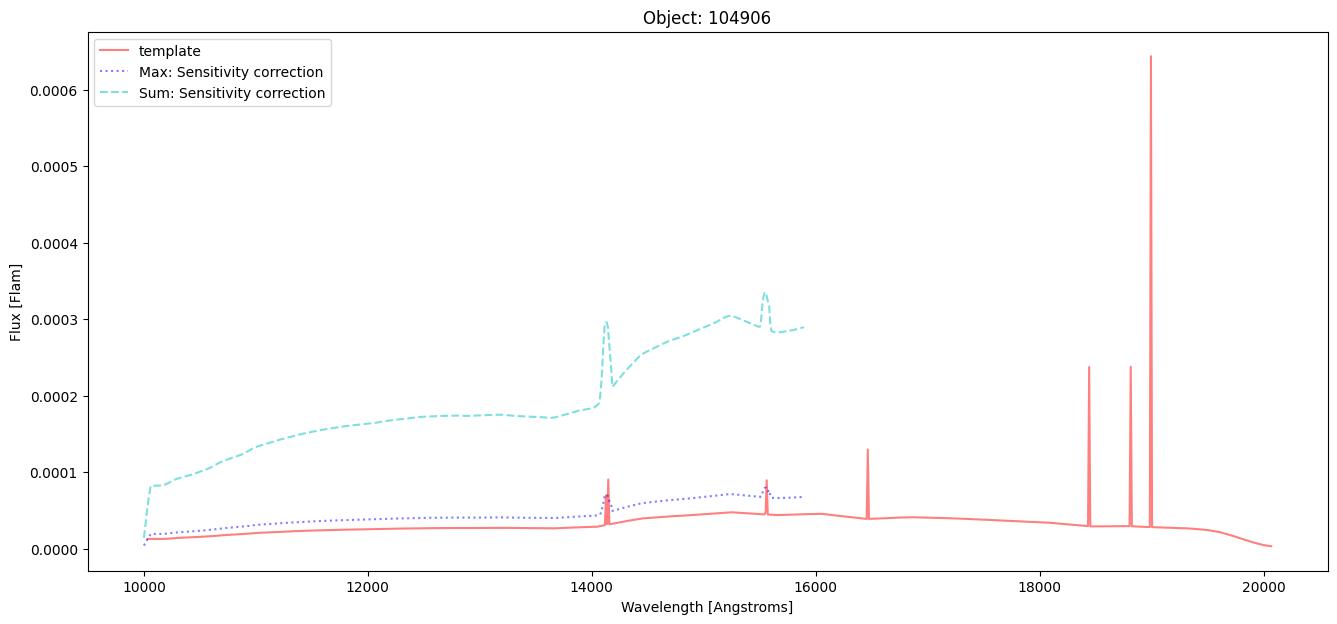

 60%|██████    | 3/5 [00:00<00:00,  5.88it/s]

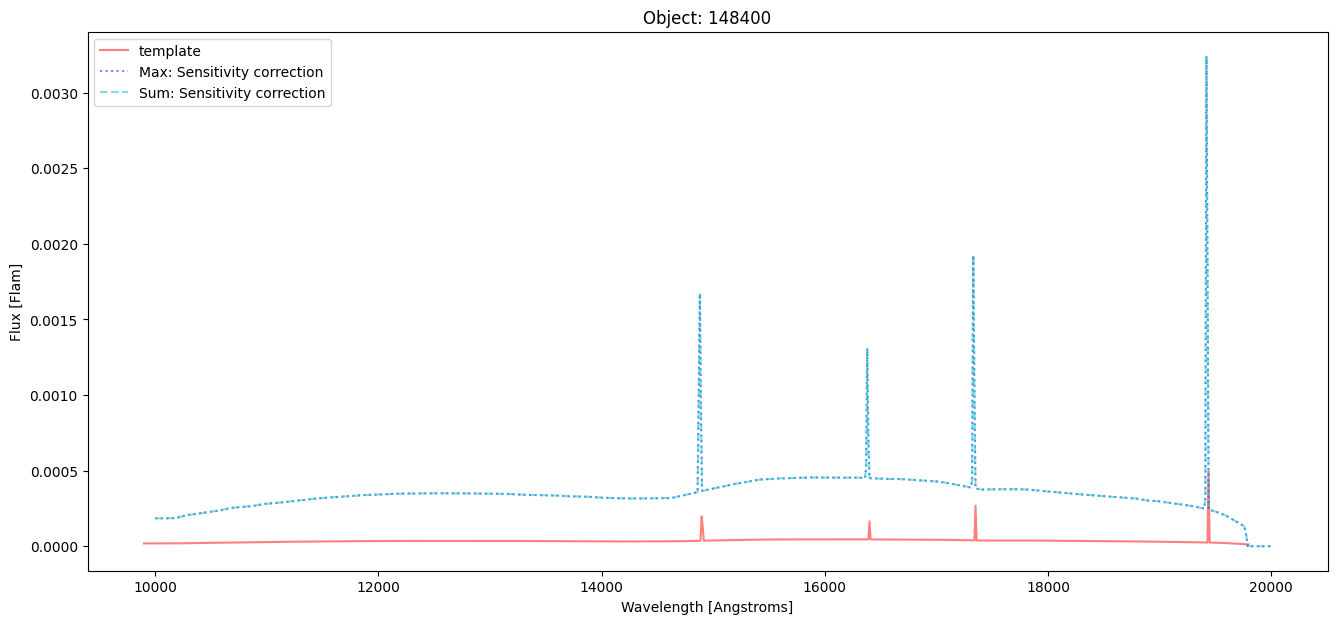

 80%|████████  | 4/5 [00:00<00:00,  5.86it/s]

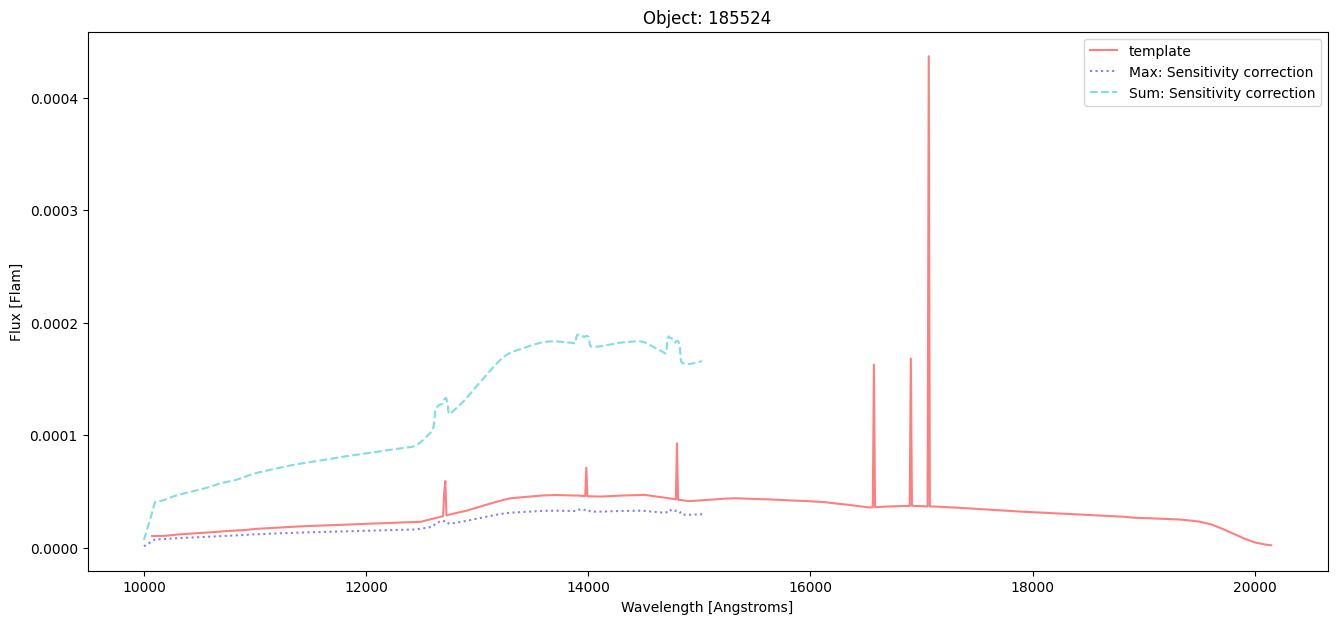

100%|██████████| 5/5 [00:00<00:00,  5.61it/s]


In [6]:
df = Table.read("/Users/keith/astr/research_astr/FOV0/FOV0_SEDs/ukg0v.dat", format="ascii")
star_spec = S.ArraySpectrum(wave=df["col1"], flux=df["col2"], waveunits="angstroms", fluxunits="flam")
del df

error_file = open("errors.txt", "w")

dictionary = {}

for object in tqdm(hlss_tbl[0:5]):
    
    # SEGMENTATION -------------------------------

    # Take object info
    id = object["NUMBER"]
    mag = object["MAG_F1500W"]
    x_0 = object["X_IMAGE"] + 100
    y_0 = object["Y_IMAGE"] + 100
    modimage = object["MODIMAGE"]
    
    # STAR
    if modimage:

        radius = max(8, min(star_radius(mag), 40)) ** 2
        circ = lambda x, y: gen_cirl(x, y, x_0, y_0)

        # Create meshgrid cutout
        x_min = max(0, int(x_0 - radius + 1)) # floor
        x_max = min(4087, int(x_0 + radius + 1) + 1) # ceil
        y_min = max(0, int(y_0 - radius + 1))
        y_max = min(4087, int(y_0 + radius + 1) + 1)
        x_cutout = np.arange(x_min, x_max)
        y_cutout = np.arange(y_min, y_max)
        x_grid, y_grid = np.meshgrid(x_cutout, y_cutout)

        condition = circ(x_grid, y_grid) <= radius

    # GALAXY
    else:
        a = object["A_IMAGE"]
        b = object["B_IMAGE"]
        theta = object["THETA_IMAGE"] * (np.pi / 180)
        radius = 4 ** 2

      # Create meshgrid cutout
        x_min = max(0, int(x_0 - radius + 1))
        x_max = min(4288, int(x_0 + radius + 1) + 1)
        y_min = max(0, int(y_0 - radius + 1))
        y_max = min(4288, int(y_0 + radius + 1) + 1)
        x_cutout = np.arange(x_min, x_max)
        y_cutout = np.arange(y_min, y_max)
        x_grid, y_grid = np.meshgrid(x_cutout, y_cutout)

        ellipse = lambda x,y: gen_ellipse(x, y, x_0, y_0, (theta, a, b))
        condition = ellipse(x_grid, y_grid) <= radius

    temp_seg = np.zeros((4288,4288))
    temp_seg[y_min:y_max, x_min:x_max][np.where(condition)] = id 

    if not np.any(temp_seg):
        error_file.write("ID {0} not in temp_seg \n".format(id))
        continue
    roman_sim.seg = np.rot90(temp_seg,k=3).astype("float32")

    # SIMULATION ---------------------------------

    # STAR
    if object["MODIMAGE"]:

        # G0V type star spectra read in above by WebbPSF
        spec = star_spec.renorm(mag, "abmag", bp)
        spec.convert("flam")

    # GALAXY
    else:
        # Read in Galaxy Spectrum
        sed_path = os.path.join(SED_dir, "SED:rest:gal.{0}.fits".format(object["SPECTEMP"]))
        spectrum = Table.read(sed_path, format="fits")
        wave = spectrum["wavelength"]
        flux = spectrum["flux"]
        z = object['Z']

        spec = S.ArraySpectrum(wave=wave, flux=flux, waveunits="angstrom", fluxunits="flam").redshift(z)
        spec = spec.renorm(mag, "abmag", bp)
        spec.convert("flam")

    # Disperse Object
    model = np.rot90(roman_sim.compute_model_orders(id, mag=mag, compute_size=False, size=77, in_place=False, 
                                                        store=False, is_cgs=True, spectrum_1d=[spec.wave, spec.flux]
                                                        )[1][pad:-pad, pad:-pad])

    fig, ax = plt.subplots()

    dictionary[id] = {}
    dictionary[id]["extracts"] = main(object, model, plot=True, ax=ax)
    dictionary[id]["template"] = spec

error_file.close()

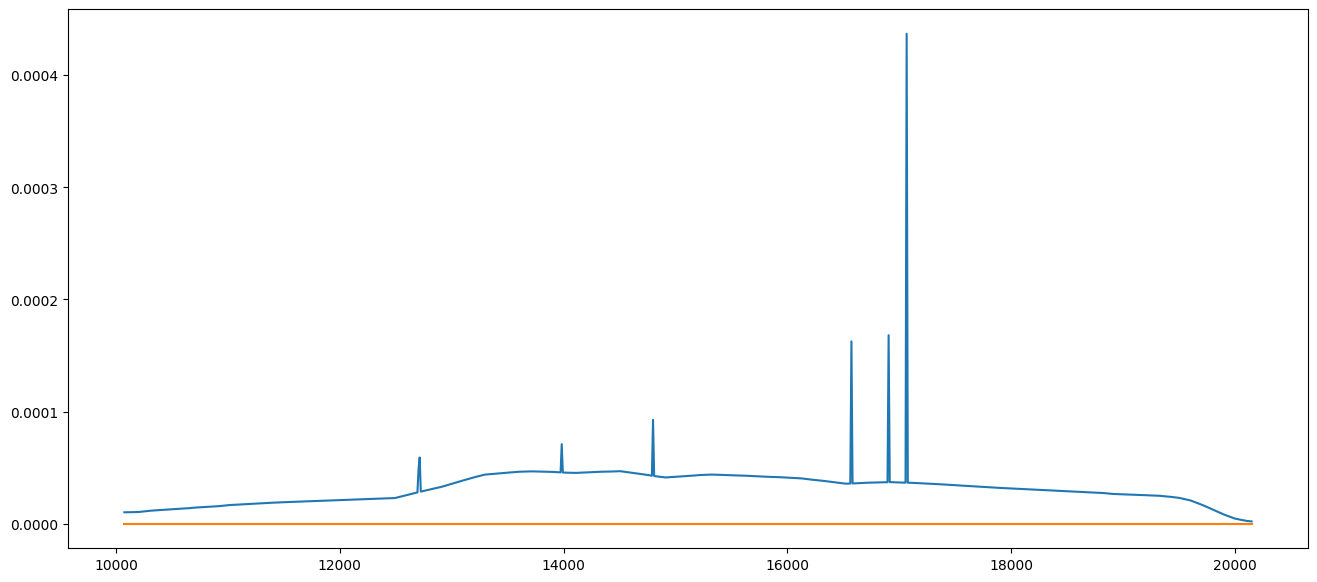

In [7]:
plt.plot(dictionary[185524]["extracts"]["template"].wave, dictionary[185524]["extracts"]["template"].flux)
plt.plot(dictionary[185524]["template"].wave, dictionary[185524]["template"].flux)